In [1]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
import os
from torchsummary import summary

In [2]:
df = pd.read_csv('data.csv')

In [3]:
train = df[df['tv']==0]
valid = df[df['tv']==1]

In [4]:
wav, sr = librosa.load('all_data/0001-1.wav', sr=48000)
print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds')

Sampling rate of the audio is 48000 and length of the audio is 9.008958333333334 seconds


In [5]:
def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled

In [6]:
def get_melspectrogram_db(file_path, sr=48000, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav,sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<5*sr:
    wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:5*sr]
  spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax, pad_mode='reflect')
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db

In [7]:
class ESC50Data(Dataset):
  def __init__(self, base, df, in_col, out_col):
    self.df = df
    self.data = []
    self.labels = []
    self.c2i={}
    self.i2c={}
    self.categories = sorted(df[out_col].unique())
    for i, category in enumerate(self.categories):
      self.c2i[category]=i
      self.i2c[i]=category
    for ind in tqdm(range(len(df))):
      row = df.iloc[ind]
      file_path = os.path.join(base,row[in_col])
      self.data.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...])
      self.labels.append(self.c2i[row['category']])
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

In [8]:
class ESC50Model(nn.Module):
  def __init__(self, input_shape):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size = 1, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 32, kernel_size = 1, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=1, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 64, kernel_size=1, stride=1, padding=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.conv5 = nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=1)
    self.bn5 = nn.BatchNorm2d(128)
    self.conv6 = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=1)
    self.bn6 = nn.BatchNorm2d(128)
    self.conv7 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=1)
    self.bn7 = nn.BatchNorm2d(256)
    self.conv8 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=1)
    self.bn8 = nn.BatchNorm2d(256)
    self.dense1 = nn.Linear(256, 64)
    self.dropout = nn.Dropout(0.5)
    self.dense2 = nn.Linear(64, 1)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(self.bn1(x))
    x = self.conv2(x)
    x = F.relu(self.bn2(x))
    x = F.max_pool2d(x, kernel_size=1) 
    x = self.conv3(x)
    x = F.relu(self.bn3(x))
    x = self.conv4(x)
    x = F.relu(self.bn4(x))
    x = F.max_pool2d(x, kernel_size=1)
    x = self.conv5(x)
    x = F.relu(self.bn5(x))
    x = self.conv6(x)
    x = F.relu(self.bn6(x))
    x = F.max_pool2d(x, kernel_size=1)
    x = self.conv7(x)
    x = F.relu(self.bn7(x))
    x = self.conv8(x)
    x = F.relu(self.bn8(x))
    x = x.view(x.size(0),-1)
    x = F.relu(self.dense1(x))
    x = self.dropout(x)
    x = self.dense2(x)
    x = x.squeeze(-1)
    return x

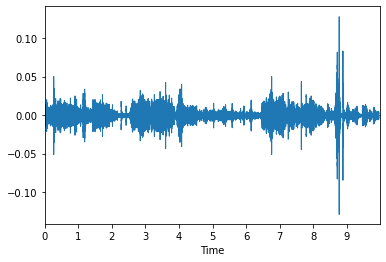

In [9]:
filename = valid[valid['category']=='wheezing'].iloc[0]['filename']
wav, sr = librosa.load('all_data/'+filename, sr=48000)
librosa.display.waveplot(wav, sr)

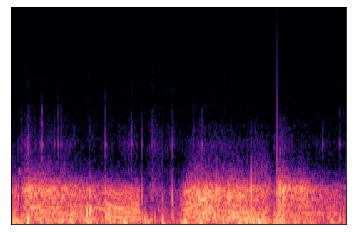

In [10]:
librosa.display.specshow(spec_to_image(get_melspectrogram_db('all_data/'+filename, sr=48000)))

In [11]:
train_data = ESC50Data('all_data', train, 'filename', 'category')

/home/nextgen/anaconda3/envs/kbs_breath/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/211 [00:00<?, ?it/s]

In [12]:
valid_data = ESC50Data('all_data', valid, 'filename', 'category')

/home/nextgen/anaconda3/envs/kbs_breath/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/52 [00:00<?, ?it/s]

In [13]:
train_loader = DataLoader(train_data, shuffle=True)
valid_loader = DataLoader(valid_data, shuffle=True)

In [14]:
for epoch in range(2):
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs = np.array(inputs)
        print(inputs.shape)
        # Run your training process
        print(f'Epoch: {i} | Inputs {inputs} | Labels {labels}')

(1, 1, 128, 469)
Epoch: 0 | Inputs [[[[133 146 168 ... 210 200 195]
   [ 58 114 142 ... 188 174 172]
   [ 73 103 116 ... 150 141 169]
   ...
   [  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]]]] | Labels tensor([0])
(1, 1, 128, 469)
Epoch: 1 | Inputs [[[[182 187 173 ... 169 179 188]
   [163 170 154 ... 158 161 163]
   [151 153 129 ... 158 155 159]
   ...
   [103  84   0 ...   0   0   0]
   [ 86  68   0 ...   0   0   0]
   [ 73  55   0 ...   0   0   0]]]] | Labels tensor([0])
(1, 1, 128, 469)
Epoch: 2 | Inputs [[[[211 214 203 ... 173 187 188]
   [213 195 203 ... 175 189 202]
   [200 205 210 ... 159 181 193]
   ...
   [  9   1   0 ...   0   0   0]
   [  9   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]]]] | Labels tensor([1])
(1, 1, 128, 469)
Epoch: 3 | Inputs [[[[189 206 201 ... 148 168 166]
   [162 199 197 ... 147 144 138]
   [188 183 173 ... 132 112 130]
   ...
   [ 18   0   0 ...   0   0   0]
   [ 11   0   0 ...   0   0   0]
 

(1, 1, 128, 469)
Epoch: 194 | Inputs [[[[218 221 209 ... 177 131 167]
   [211 221 216 ... 161 178 176]
   [183 202 218 ... 172 187 184]
   ...
   [  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]]]] | Labels tensor([1])
(1, 1, 128, 469)
Epoch: 195 | Inputs [[[[167 170 174 ...  88 101  99]
   [140 152 158 ...  77  84  76]
   [125 119 128 ...  84  84  58]
   ...
   [  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]]]] | Labels tensor([0])
(1, 1, 128, 469)
Epoch: 196 | Inputs [[[[194 194 176 ... 164 144 125]
   [159 166 163 ... 136 127 111]
   [102 144 145 ... 102 105 100]
   ...
   [  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]
   [  0   0   0 ...   0   0   0]]]] | Labels tensor([0])
(1, 1, 128, 469)
Epoch: 197 | Inputs [[[[235 244 246 ... 196 199 206]
   [217 218 217 ... 188 189 196]
   [185 181 157 ... 177 175 172]
   ...
   [ 21  22  15 ...   0   0   0]
   [ 44  32  13 ...   3   

In [15]:
if torch.cuda.is_available():
  device=torch.device('cuda')
else:
  device=torch.device('cpu')

In [16]:
model = ESC50Model(input_shape=(1,128,469)).to(device)

In [17]:
summary(model, (1,128,469))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 130, 471]              64
       BatchNorm2d-2         [-1, 32, 130, 471]              64
            Conv2d-3         [-1, 32, 132, 473]           1,056
       BatchNorm2d-4         [-1, 32, 132, 473]              64
            Conv2d-5         [-1, 64, 134, 475]           2,112
       BatchNorm2d-6         [-1, 64, 134, 475]             128
            Conv2d-7         [-1, 64, 136, 477]           4,160
       BatchNorm2d-8         [-1, 64, 136, 477]             128
            Conv2d-9        [-1, 128, 138, 479]           8,320
      BatchNorm2d-10        [-1, 128, 138, 479]             256
           Conv2d-11        [-1, 128, 140, 481]          16,512
      BatchNorm2d-12        [-1, 128, 140, 481]             256
           Conv2d-13        [-1, 256, 142, 483]          33,024
      BatchNorm2d-14        [-1, 256, 1

/home/nextgen/anaconda3/envs/kbs_breath/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [18]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

In [19]:
loss_fn = nn.BCELoss()
learning_rate = 2e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 60
train_losses = []
valid_losses = []

In [20]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.float32)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [21]:
def lr_decay(optimizer, epoch):
  if epoch%20==0:
    new_lr = learning_rate / (10**(epoch//20))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

/home/nextgen/anaconda3/envs/kbs_breath/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/60 [00:00<?, ?it/s]

RuntimeError: Function AddmmBackward returned an invalid gradient at index 1 - got [1, 256] but expected shape compatible with [1, 17879040]